In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import requests
import gmaps
import os
import json
import sys
sys.path.insert(0, 'Data')
from config import g_key

#Store Part I results into DataFrame
#Load the data to a DataFrame
accident_data = pd.read_csv("Data/accident_data.csv", encoding="utf-8")
accident_data.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [3]:
# Data cleanup

# Filters out dates containing 2016, 2017, & 2019 -- too much data in dataset to handle with laptops
accident_data_revised = accident_data[~accident_data["Start_Time"].str.contains("2016")]
accident_data_revised = accident_data_revised[~accident_data_revised["Start_Time"].str.contains("2017")]
accident_data_revised = accident_data_revised[~accident_data_revised["Start_Time"].str.contains("2019")]

# Splits the Start_Time column into individual columns
accident_data_revised[["Date", "Time"]] = accident_data_revised["Start_Time"].str.split(expand=True)

# Renames columns to be more readable
accident_data_revised = accident_data_revised.rename(columns={"Start_Lat":"Lat", "Start_Lng":"Lng", "Weather_Condition":"Weather"})

# Filters and rearranges dataset to display most useful columns
accident_data_revised = accident_data_revised[["Date", "Time", "Lat", "Lng", "City", "State",
         "County", "Weather", "Temperature(F)", "Severity", "Nautical_Twilight"]]

# Iterates through all column data to find NaN values and adds them to a list
accident_data_revised.columns[accident_data_revised.isna().any()].tolist()

accident_data_revised = accident_data_revised.reset_index()

accident_data_revised.head(20)

,index,Date,Time,Lat,Lng,City,State,County,Weather,Temperature(F),Severity,Nautical_Twilight
0,626043,2018-12-31,23:54:51,40.740047,-73.818512,Flushing,NY,Queens,Heavy Rain,46.9,3,Night
1,626045,2018-12-31,22:40:11,40.834370,-73.864113,Bronx,NY,Bronx,Rain,46.4,3,Night
2,626355,2018-12-31,12:35:54,38.441975,-88.953049,Dix,IL,Jefferson,Light Rain,57.0,3,Day
3,626407,2018-12-31,22:32:27,30.241417,-97.726158,Austin,TX,Travis,Partly Cloudy,39.9,2,Night
4,626462,2018-12-31,23:49:55,32.773060,-96.744247,Dallas,TX,Dallas,Clear,43.0,2,Night
5,626463,2018-12-31,23:49:24,32.818420,-96.802391,Dallas,TX,Dallas,Clear,43.0,2,Night
6,626563,2018-12-31,18:46:51,39.902153,-104.988914,Denver,CO,Adams,Snow,8.6,3,Night
7,626574,2018-12-31,22:26:47,32.192139,-110.857933,Tucson,AZ,Pima,Light Rain,37.4,2,Night
8,626599,2018-12-31,22:40:29,35.008537,-105.664352,Moriarty,NM,Torrance,Light Snow,27.9,3,Night
9,626602,2018-12-31,22:37:23,35.423836,-108.312744,Continental Divide,NM,McKinley,Light Snow,25.0,3,Night


In [8]:
# Renames most columns in weather data to lessen graph density

accident_data_revised["Weather"] = accident_data_revised["Weather"].replace({
    
    # Cloudy conditions
    "Mostly Cloudy":"Cloudy",
    "Scattered Clouds":"Cloudy",
    "Partly Cloudy":"Cloudy",
    
    # Rainy conditions
    "Light Rain":"Rain",
    "Heavy Rain":"Rain",
    "Light Drizzle":"Rain",
    "Light Thunderstorms and Rain":"Rain",
    "Heavy Thunderstorms and Rain":"Rain",
    "Heavy Rain Showers":"Rain",
    "Drizzle":"Rain",
    "Storm":"Rain",
    "Light Freezing Rain":"Rain",
    "Heavy Drizzle":"Rain",
    "Thunderstorms and Rain":"Rain",
    "Light Freezing Drizzle":"Rain",
    "Light Rain Showers":"Rain",
    "Light Thunderstorm":"Rain",
    "Heavy Freezing Rain":"Rain",
    "Heavy Freezing Drizzle":"Rain",
    "Squalls":"Rain",
    "Rain Showers":"Rain",
    "Thunderstorm":"Rain",
    
    # Foggy conditions
    "Patches of Fog":"Fog",
    "Shallow Fog":"Fog",
    "Mist":"Fog",
    "Light Freezing Fog":"Fog",
    "Haze":"Fog",
    "Light Haze":"Fog",
    
    # Snow conditions
    "Light Snow":"Snow",
    "Blowing Snow":"Snow",
    "Light Snow Showers":"Snow",
    "Heavy Snow":"Snow",
    "Light Snow Grains":"Snow",
    "Light Thunderstorms and Snow":"Snow",
    "Heavy Blowing Snow":"Snow",
    "Light Blowing Snow":"Snow",
    "Thunderstorms and Snow":"Snow",
    "Snow Showers":"Snow",
    
    # Other conditions
    "Hail":"Misc/Other",
    "Light Ice Pellets":"Misc/Other",
    "Small Hail":"Misc/Other",
    "Light Hail":"Misc/Other",
    "Heavy Thunderstorms with Small Hail":"Misc/Other",
    "Ice Pellets":"Misc/Other",
    "Smoke":"Misc/Other",
    "Heavy Smoke":"Misc/Other",
    "Volcanic Ash":"Misc/Other",
    "Widespread Dust":"Misc/Other",
    "Sand":"Misc/Other",
    "Funnel Cloud":"Misc/Other"
})

accident_data_revised["Weather"].value_counts()

Clear         308073
Cloudy        287066
Overcast      156658
Rain           72261
Fog            20380
Snow           17283
Misc/Other      1732
Name: Weather, dtype: int64

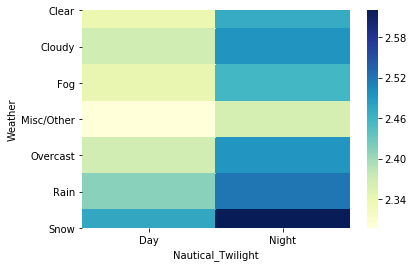

In [14]:
heatmap1_data = pd.pivot_table(accident_data_revised, values='Severity', 
                     index=['Weather'], 
                     columns=['Nautical_Twilight'])
sb.heatmap(heatmap1_data, cmap="YlGnBu")

In [ ]:
heatmap1_data = sb.heatmap(accident_data_revised, xticklabels=False, yticklabels=False)
heatmap1_data = sb.heatmap(accident_data_revised, yticklabels=False)